In [1]:
# create feature pickles to use around the place
# humpback whale pickle with new annots
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)


['/Users/david/Documents/mastersCode/ubm/final/tests/get_features', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import utils
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import librosa

def get_feature(samp, nfft):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=4000, n_mfcc=20, n_fft=256).T
    feat = useful.get_log_power_feature(samp, nfft=nfft)
    return feat

In [4]:
from whale.setup import get_data, constants, annotations
import importlib
importlib.reload(constants)

importlib.reload(get_data)
from final import useful
importlib.reload(useful)

HUMPBACK_A = 'humpback_a'
HUMPBACK_B = 'humpback_b'
BOWHEAD = 'bowhead'
NOISE = 'noise'

# constants for fe and what not
fs = 4000
nfft = 256

signal_types = [HUMPBACK_A] #, HUMPBACK_B, BOWHEAD, NOISE]

# type to label
signal_types_labels = {
    HUMPBACK_A: 0,
    # HUMPBACK_B: 1,
    # BOWHEAD: 2,
    # NOISE: 3
}

# label to type
label_to_type = {
    0: HUMPBACK_A,
    1: HUMPBACK_B,
    2: BOWHEAD,
    3: NOISE
}

get_data_dict = {
    HUMPBACK_A: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_SWOOPS_TIME_DOMAIN, fs, useful.file_to_audio)]
}

samples, labels = useful.get_samples(get_data_dict, signal_types, signal_types_labels)

__collected samples__
humpback_a :  32


In [5]:
all_features = []
for sample in samples:
    all_features.append(get_feature(sample, nfft))

In [8]:
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)

n_folds = 6
cv_output = cv.split_data_for_cross_validation(all_features, labels, n_folds, test_ratio=0.01)

In [9]:
import pickle
# Pickle for reading in Python
output = open('humpback_cv_output' + ".pkl", "wb")
pickle.dump(cv_output, output)
output.close()

In [91]:
cv_index = 0
train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])

In [92]:
train.features = []
for sample in train.samples:
    train.features.append(get_feature(sample, nfft))

val.features = []
for sample in val.samples:
    val.features.append(get_feature(sample, nfft))

features_0 = {
    train: train,
    val: val
}

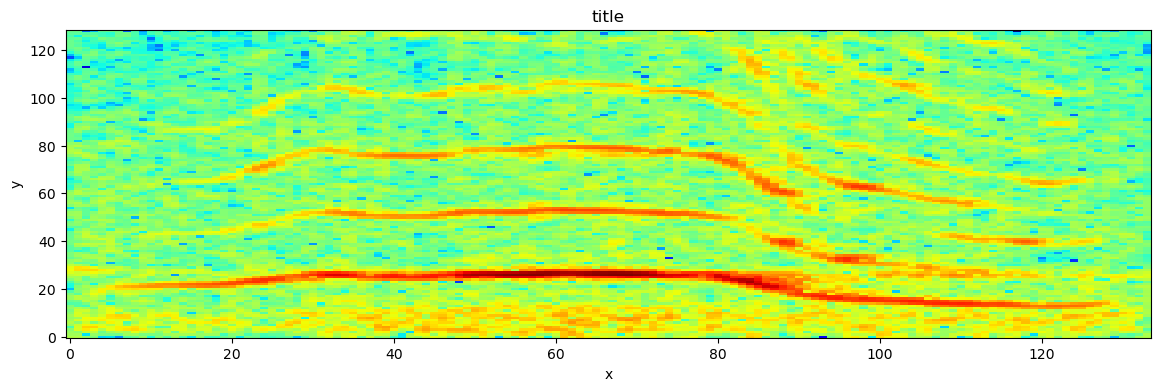

In [93]:
utils.plot_spectrogram(train.features[4])

In [94]:
# train
features_concat = np.vstack(train.features)
features_len = [0]
n_doc = 0
rolling_total = 0

for i in range(len(train.features)):
    features_len.append(len(train.features[i]) + rolling_total)
    rolling_total += len(train.features[i])
    n_doc += 1

class MyGroupXData:
    def __init__(self, X, TrueParams, Xprev, column_names, dim, doc_range, nDoc, nDocTotal, true_state_names):
        self.X = X
        self.TrueParams = TrueParams
        self.Xprev = Xprev
        self.column_names = column_names
        self.dim = dim
        self.doc_range = doc_range
        self.nDoc = nDoc
        self.nDocTotal = nDocTotal
        self.true_state_names = true_state_names

bnpy_dataset = MyGroupXData(
    features_concat,
    {},
    features_concat, np.array([]), features_concat.shape[1],
    np.array(features_len), n_doc, n_doc, np.array([]))

bnpy_dataset.TrueParams['Z'] = np.zeros(bnpy_dataset.X.shape[0])
bnpy_dataset.TrueParams['K'] = 10

In [ ]:
import pickle
# Pickle for reading in Python
output = open('humpback_v1_bnpy_dataset' + ".pkl", "wb")
pickle.dump(bnpy_dataset, output)
output.close()


In [120]:
output = open('humpback_v1_bnpy_dataset_val' + ".pkl", "wb")
pickle.dump([train.features, val.features], output)
output.close()

In [95]:
# /Users/david/Documents/mastersCode/ubm/final/tests/get_features/humpback_v1.pkl


In [110]:
from hmmlearn.hmm import GaussianHMM

def normalize_matrix(matrix):
    matrix += 1e-40
    return matrix / np.sum(matrix, axis=(matrix.ndim - 1), keepdims=True)

def get_hmm_from_bnp(bnpy_params):
    # creat hmm
    hmm_bnpy = GaussianHMM(n_components=len(bnpy_params['pi']), covariance_type='diag', init_params='')
    hmm_bnpy.n_features = bnpy_params['means'].shape[1]
    hmm_bnpy.transmat_, hmm_bnpy.startprob_, hmm_bnpy.means_ = \
        normalize_matrix(bnpy_params['A']), normalize_matrix(bnpy_params['pi']), bnpy_params['means']
    hmm_bnpy.covars_ = bnpy_params['covars']
    return hmm_bnpy

def score_hmm(some_hmm: GaussianHMM, features_array):
    scores = []
    for i in range(len(features_array)):
        scores.append(some_hmm.score(features_array[i]) / len(features_array[i]))
    print(np.sum(scores))

In [113]:
# np.sum([len(feat) for feat in val.features])
# len(np.concatenate(val.features))
# hmm_bnpy.score(np.concatenate(val.features), [len(feat) for feat in val.features])
hmm_bnpy_params = pickle.load(open(r'humpback_v1_bnpy.pkl', 'rb'))
hmm_bnpy_inf = get_hmm_from_bnp(hmm_bnpy_params)
score_hmm(hmm_bnpy_inf, val.features)

-4121.527308537601


In [122]:
hmm_bnpy_params_fin = pickle.load(open(r'humpback_v1_bnpy_finite.pkl', 'rb'))
hmm_bnpy_fin = get_hmm_from_bnp(hmm_bnpy_params_fin)
score_hmm(hmm_bnpy_fin, val.features)

-4130.720037111644


In [116]:
hmm_bnpy_params_em = pickle.load(open(r'humpback_v1_bnpy_finite_em.pkl', 'rb'))
hmm_bnpy_em = get_hmm_from_bnp(hmm_bnpy_params_em)
score_hmm(hmm_bnpy_em, val.features)

-4011.275237299567


In [117]:
hmm_em = GaussianHMM(n_components=hmm_bnpy_em.n_components, covariance_type='diag')
hmm_em.fit(features_concat, [len(feat) for feat in train.features])
score_hmm(hmm_em, val.features)

-4045.4698365868853


-170109.73696452862